<a href="https://colab.research.google.com/github/AadiSharmaa/Customer-Satisfaction-Prediction/blob/main/Customer_Satisfaction_Prediction_with_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation

# --- Download NLTK data (only need to run once) ---
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('omw-1.4')


1. Load and Preprocess Data

In [5]:
# Load the dataset
try:
    df = pd.read_csv('customer_support_tickets.csv')
except FileNotFoundError:
    print("Make sure 'customer_support_tickets.csv' is in the same directory.")
    exit()

# Drop irrelevant columns for this analysis
df.drop(['Customer Name', 'Customer Email', 'Ticket ID'], axis=1, inplace=True)
# --- Feature Engineering & Cleaning ---

# Convert date columns to datetime objects
df['Date of Purchase'] = pd.to_datetime(df['Date of Purchase'])
df['First Response Time'] = pd.to_datetime(df['First Response Time'])
df['Time to Resolution'] = pd.to_datetime(df['Time to Resolution'])

# Calculate response and resolution times in hours
df['Response Time (hours)'] = (df['First Response Time'] - df['Date of Purchase']).dt.total_seconds() / 3600
df['Resolution Time (hours)'] = (df['Time to Resolution'] - df['First Response Time']).dt.total_seconds() / 3600

# For this analysis, we will focus on resolved tickets that have a satisfaction rating
df_resolved = df.dropna(subset=['Customer Satisfaction Rating', 'Resolution Time (hours)']).copy()
df_resolved['Customer Satisfaction Rating'] = df_resolved['Customer Satisfaction Rating'].astype(int)

# --- NLP Preprocessing for Ticket Descriptions ---
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Cleans and preprocesses text for NLP."""
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    tokens = text.split()
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to ticket descriptions
df_resolved['Processed Description'] = df_resolved['Ticket Description'].apply(preprocess_text)

2. Topic Modeling with LDA

In [6]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
dtm = tfidf_vectorizer.fit_transform(df_resolved['Processed Description'])

# Apply Latent Dirichlet Allocation (LDA)
n_topics = 5 # Define the number of topics to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(dtm)

# Display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("--- Top Words per Topic (from LDA) ---")
display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)
print("-" * 30)

# Assign the most likely topic to each ticket
topic_results = lda.transform(dtm)
df_resolved['Topic'] = topic_results.argmax(axis=1)

--- Top Words per Topic (from LDA) ---
Topic 1:
im account assist support ive unable option step action perform
Topic 2:
resolve ive data hoping factory performed help reset didnt file
Topic 3:
im fine facing problem device change recent act intermittent unexpectedly
Topic 4:
persists tried different user mentioned manual ive troubleshooting assist step
Topic 5:
recently screen message possible mean im say peculiar popping errormessage
------------------------------


3. Predictive Modeling

In [7]:
# Prepare data for the model
# Select features, including the new 'Topic' feature
features = [
    'Customer Age', 'Customer Gender', 'Product Purchased', 'Ticket Type',
    'Ticket Priority', 'Ticket Channel', 'Response Time (hours)',
    'Resolution Time (hours)', 'Topic'
]
target = 'Customer Satisfaction Rating'

# Encode categorical features
categorical_cols = [col for col in features if df_resolved[col].dtype == 'object']
for col in categorical_cols:
    le = LabelEncoder()
    df_resolved[col] = le.fit_transform(df_resolved[col])

X = df_resolved[features]
y = df_resolved[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Gradient Boosting Regressor model
# This model is powerful and works well for this kind of tabular data
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train, y_train)

# Make predictions
y_pred = gbr.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n--- Model Evaluation ---")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")
print("-" * 30)


--- Model Evaluation ---
Mean Squared Error: 2.07
R-squared: -0.05
------------------------------


4. Insight Generation

/tmp/ipython-input-8-614074167.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')


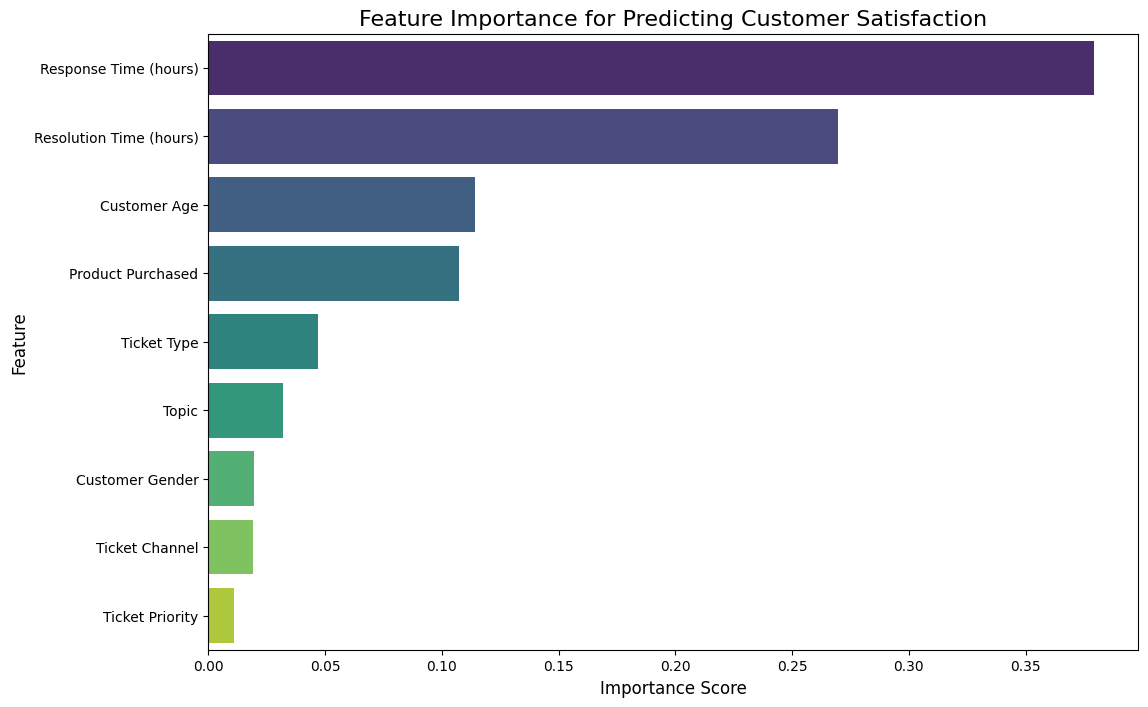

/tmp/ipython-input-8-614074167.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Topic', y='Customer Satisfaction Rating', data=topic_satisfaction, palette='plasma')


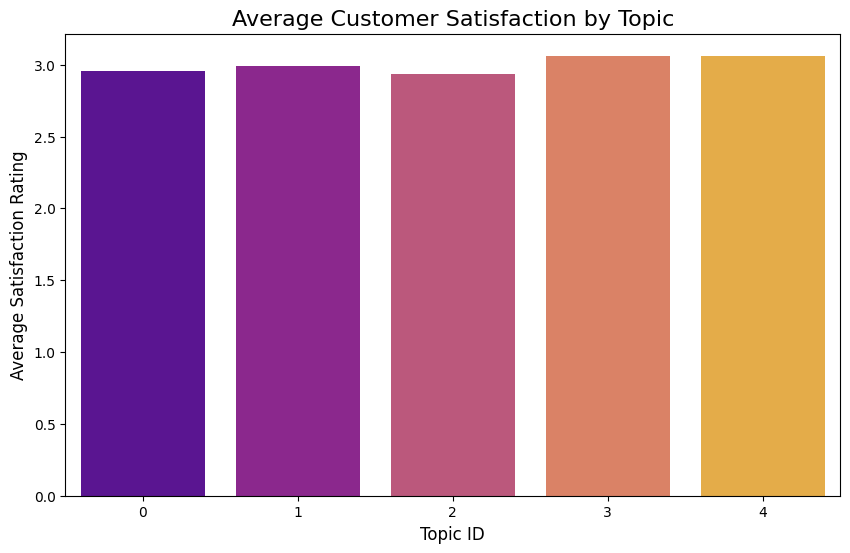

In [8]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': gbr.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Feature Importance for Predicting Customer Satisfaction', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Analyze satisfaction by topic
topic_satisfaction = df_resolved.groupby('Topic')['Customer Satisfaction Rating'].mean().reset_index()
topic_satisfaction = topic_satisfaction.sort_values(by='Customer Satisfaction Rating')

plt.figure(figsize=(10, 6))
sns.barplot(x='Topic', y='Customer Satisfaction Rating', data=topic_satisfaction, palette='plasma')
plt.title('Average Customer Satisfaction by Topic', fontsize=16)
plt.xlabel('Topic ID', fontsize=12)
plt.ylabel('Average Satisfaction Rating', fontsize=12)
plt.show()

